<a href="https://colab.research.google.com/github/soumyaunique/summeranalytics2025/blob/main/Nutrition_Health_Survey_Age_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# To suppress warnings
import warnings
warnings.filterwarnings('ignore')

Load the data

In [12]:
# Load training and test datasets
train_df = pd.read_csv('/tmp/Train_Data.csv')
test_df = pd.read_csv('/tmp/Test_Data.csv')
sample_submission = pd.read_csv('/tmp/Sample_Submission.csv')

# Check shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# View first few rows
train_df.head()

Train shape: (1966, 9)
Test shape: (312, 8)


,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


Dealing with Missing Values


Missing values in train:
SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

Missing values in test:
SEQN        2
RIAGENDR    2
PAQ605      1
BMXBMI      1
LBXGLU      1
DIQ010      1
LBXGLT      2
LBXIN       1
dtype: int64


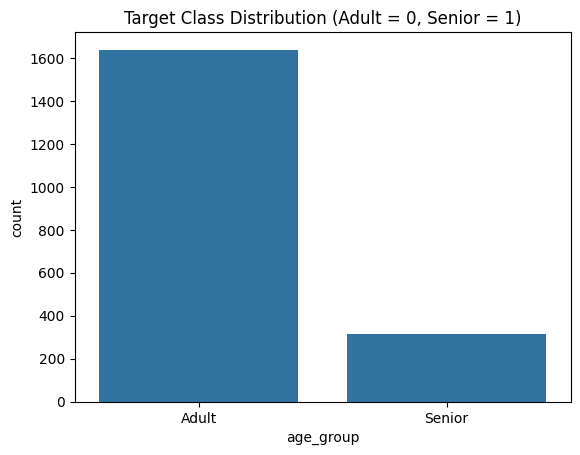

               SEQN     RIAGENDR       PAQ605       BMXBMI       LBXGLU  \
count   1954.000000  1948.000000  1953.000000  1948.000000  1953.000000   
mean   78683.621801     1.510267     1.825397    27.965400    99.491039   
std     2924.115709     0.500023     0.399449     7.327616    16.774665   
min    73564.000000     1.000000     1.000000    14.500000    63.000000   
25%    76194.000000     1.000000     2.000000    22.800000    91.000000   
50%    78717.000000     2.000000     2.000000    26.800000    97.000000   
75%    81217.000000     2.000000     2.000000    31.300000   104.000000   
max    83727.000000     2.000000     7.000000    70.100000   405.000000   

            DIQ010       LBXGLT        LBXIN  
count  1948.000000  1955.000000  1957.000000  
mean      2.015914   115.150384    11.862892  
std       0.187579    46.271615     9.756713  
min       1.000000    40.000000     0.140000  
25%       2.000000    87.000000     5.800000  
50%       2.000000   105.000000     9.0300

In [13]:
# Check for missing values
print("\nMissing values in train:")
print(train_df.isnull().sum())

print("\nMissing values in test:")
print(test_df.isnull().sum())

# Check target balance
sns.countplot(data=train_df, x='age_group')
plt.title("Target Class Distribution (Adult = 0, Senior = 1)")
plt.show()

# Describe numerical features
print(train_df.describe())

Data Preprocessing

In [14]:
# Drop SEQN (identifier column)
train_df.drop('SEQN', axis=1, inplace=True)
test_ids = test_df['SEQN']  # Save for submission
test_df.drop('SEQN', axis=1, inplace=True)

# Drop rows in train where target is missing
train_df = train_df[train_df['age_group'].notnull()]

# 🔁 Encode target labels: 'Adult' → 0, 'Senior' → 1
train_df['age_group'] = train_df['age_group'].map({'Adult': 0, 'Senior': 1})

# Separate features and target
X = train_df.drop('age_group', axis=1)
y = train_df['age_group'].astype(int)  # Make sure it's int

# Combine train features and test features for unified preprocessing
combined = pd.concat([X, test_df], axis=0)

# Impute missing values using mean strategy
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
combined_imputed = pd.DataFrame(imputer.fit_transform(combined), columns=combined.columns)

# Split combined data back into training and test sets
X_imputed = combined_imputed.iloc[:len(X), :]
X_test_imputed = combined_imputed.iloc[len(X):, :]

In [15]:
# Check for missing values
print("\nMissing values in train:")
print(X_imputed.isnull().sum())

print("\nMissing values in test:")
print(X_test_imputed.isnull().sum())


Missing values in train:
RIAGENDR    0
PAQ605      0
BMXBMI      0
LBXGLU      0
DIQ010      0
LBXGLT      0
LBXIN       0
dtype: int64

Missing values in test:
RIAGENDR    0
PAQ605      0
BMXBMI      0
LBXGLU      0
DIQ010      0
LBXGLT      0
LBXIN       0
dtype: int64


Hyper Paramter Tuning (Not to be run) -- For experimental purpose only)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [20]:
# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Grid search setup
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',  # we are optimizing for F1 score
    cv=5,
    verbose=2,
    n_jobs=-1  # use all processors
)

In [21]:
grid_search.fit(X_imputed, y)
best_model = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [22]:
from sklearn.model_selection import cross_val_score

# Evaluate F1 on cross-validation
f1_scores = cross_val_score(best_model, X_imputed, y, cv=5, scoring='f1')
print("Cross-validated F1 scores:", f1_scores)
print("Mean F1 Score:", f1_scores.mean())

Cross-validated F1 scores: [0.33333333 0.29787234 0.2826087  0.19512195 0.20224719]
Mean F1 Score: 0.26223670232835744


In [25]:
# Predict on the test set
test_preds = best_model.predict(X_test_imputed)

# Prepare submission
submission = pd.DataFrame({
    'age_group': test_preds.astype(int)
})
submission.to_csv("/tmp/final_submission_with_tuning.csv", index=False)
submission.head()

,age_group
0,0
1,0
2,0
3,0
4,0


Training

In [16]:
# Train-test split for evaluation
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Build model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Validation predictions
y_pred = rf.predict(X_val)

# Evaluate
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       340
           1       0.35      0.14      0.20        51

    accuracy                           0.85       391
   macro avg       0.62      0.55      0.56       391
weighted avg       0.81      0.85      0.83       391

Confusion Matrix:
[[327  13]
 [ 44   7]]
F1 Score: 0.19718309859154928


Prediction Time

In [18]:
# Predict on test set
test_preds = rf.predict(X_test_imputed)

# Prepare submission
submission = pd.DataFrame({
    'age_group': test_preds.astype(int)
})
submission.to_csv("/tmp/final_submission.csv", index=False)
submission.head()

,age_group
0,0
1,0
2,0
3,0
4,0
